In [19]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import os

import librosa as l
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

# Keras
import keras
import keras_metrics
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop

In [20]:
#%pip install keras_metrics

In [21]:
final_df = pd.read_csv('../Datasets/final_df.csv')

# drop first column
final_df.drop('Unnamed: 0', axis='columns', inplace=True)

# train-test split dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

final_df_testing = final_df.copy()
final_df_testing = shuffle(final_df_testing)

X = final_df_testing.drop(columns=['Path', 'Emotions_without_gender','Emotions_with_gender'], axis=1)
y = final_df_testing['Emotions_with_gender']
print(X.shape, y.shape)

(11682, 173) (11682,)


In [22]:
# Handle imbalance classes with SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

print('Original dataset shape', Counter(y))
print('\n')
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({4: 1096, 3: 1096, 6: 1096, 2: 1096, 0: 1096, 5: 960, 10: 767, 8: 767, 14: 767, 11: 767, 12: 767, 13: 623, 7: 496, 9: 96, 15: 96, 1: 96})


Resample dataset shape Counter({4: 1096, 5: 1096, 10: 1096, 3: 1096, 8: 1096, 13: 1096, 6: 1096, 14: 1096, 2: 1096, 9: 1096, 11: 1096, 12: 1096, 15: 1096, 7: 1096, 0: 1096, 1: 1096})


In [23]:
X_train

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,MEL124,MEL125,MEL126,MEL127,TONZ0,TONZ1,TONZ2,TONZ3,TONZ4,TONZ5
4216,-375.720900,129.392560,7.362418,46.663933,-17.437948,12.403375,-4.709031,2.517186,-14.198625,9.782601,...,1.575326e-09,1.541465e-09,1.519516e-09,1.506017e-09,0.029122,-0.005699,-0.051792,-0.039562,0.028148,-0.012258
13474,-320.247489,106.164040,1.219125,47.121058,-6.797342,16.303472,-14.499918,7.160887,-17.319973,-2.350949,...,2.192512e-09,2.154141e-09,2.129621e-09,2.114307e-09,-0.004479,-0.007515,-0.049043,-0.051159,0.014734,0.000277
2344,-433.694430,137.347840,3.887333,66.726460,-14.965562,30.261938,-32.210230,14.495071,-13.176215,7.930986,...,3.660112e-09,3.606480e-09,3.572733e-09,3.551508e-09,0.008889,0.006211,-0.032803,-0.015761,0.014712,-0.008516
15889,-425.188902,147.881574,9.910328,57.323356,-15.554879,20.033053,-9.046137,8.779259,-18.211343,1.961533,...,2.122194e-09,2.090448e-09,2.070207e-09,2.057418e-09,-0.028159,-0.004171,-0.037697,-0.058922,0.016713,-0.005535
15538,-347.569744,125.420641,16.041150,37.771224,1.351183,12.132444,-12.615535,-2.587660,-13.006554,0.008664,...,3.058701e-09,3.009701e-09,2.978476e-09,2.958817e-09,0.007924,0.011472,-0.068505,0.014808,0.008324,0.007138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-582.655330,40.385450,-6.514298,3.869539,-6.550285,-10.057134,-12.808717,-11.570229,-5.127692,-3.605538,...,3.945397e-03,4.191024e-03,2.213589e-03,1.883421e-04,-0.028526,0.023054,-0.021863,-0.004716,0.011163,0.004888
11964,-726.346664,59.138943,-2.238602,5.039176,3.046652,-7.384279,-15.102103,-11.149681,-3.885113,1.008559,...,1.985113e-05,1.660627e-05,1.132797e-05,8.031817e-07,-0.017063,0.025149,-0.026597,-0.036063,-0.003980,-0.012002
5390,-327.158660,29.121696,6.746355,10.448345,-26.812729,-2.547944,0.408333,-16.676817,-8.961535,-0.172638,...,1.710167e-02,2.183831e-02,1.631187e-02,1.711896e-03,-0.021021,0.036626,0.004792,-0.071661,0.010012,0.005186
860,-456.924900,65.878540,17.076363,-9.455778,4.585947,2.319684,-4.544697,1.757438,-11.565870,-2.955083,...,4.267705e-04,3.263328e-04,1.714644e-04,1.486852e-05,-0.029017,-0.003383,-0.058347,0.082560,0.011328,-0.003832


In [24]:
model = tf.keras.Sequential()

model.add(layers.Conv1D(128, kernel_size=5, strides=1, # first convulational layer
                        padding="same", activation="relu",
                        input_shape=(X_smote.shape[1], 1))) 
model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(64, kernel_size=5, strides=1,  # second convulational layer
                        padding="same", activation="relu"))
model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Flatten()) # flatten into a 1D array
model.add(layers.Dense(128, activation='relu')) # fully connected layer
model.add(layers.Dense(64, activation='relu')) # fully connected layer

model.add(layers.Dense(16, activation="softmax")) # output layer

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 173, 128)          768       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 87, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 87, 64)            41024     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 44, 64)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2816)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [25]:
# Compile the model with appropriate Loss function
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

#sparse_categorical_crossentropy --> when targets are integer & suitable for multiclasses
#categorical_crossentropy --> when targets are one-hot encoded vectors (binary) 

In [26]:
epochs = 100
 
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test)) 

Epoch 1/100
439/439 [==============================] - 17s 38ms/step - loss: 2.1617 - accuracy: 0.3300 - val_loss: 1.8009 - val_accuracy: 0.4242
Epoch 2/100
439/439 [==============================] - 16s 37ms/step - loss: 1.6884 - accuracy: 0.4692 - val_loss: 1.5588 - val_accuracy: 0.5094
Epoch 3/100
439/439 [==============================] - 16s 36ms/step - loss: 1.4943 - accuracy: 0.5203 - val_loss: 1.4284 - val_accuracy: 0.5334
Epoch 4/100
439/439 [==============================] - 16s 37ms/step - loss: 1.3712 - accuracy: 0.5540 - val_loss: 1.3816 - val_accuracy: 0.5527
Epoch 5/100
439/439 [==============================] - 16s 37ms/step - loss: 1.2923 - accuracy: 0.5713 - val_loss: 1.2806 - val_accuracy: 0.5750
Epoch 6/100
439/439 [==============================] - 16s 37ms/step - loss: 1.2196 - accuracy: 0.5933 - val_loss: 1.2394 - val_accuracy: 0.5753
Epoch 7/100
439/439 [==============================] - 16s 37ms/step - loss: 1.1743 - accuracy: 0.6060 - val_loss: 1.2007 - val_ac

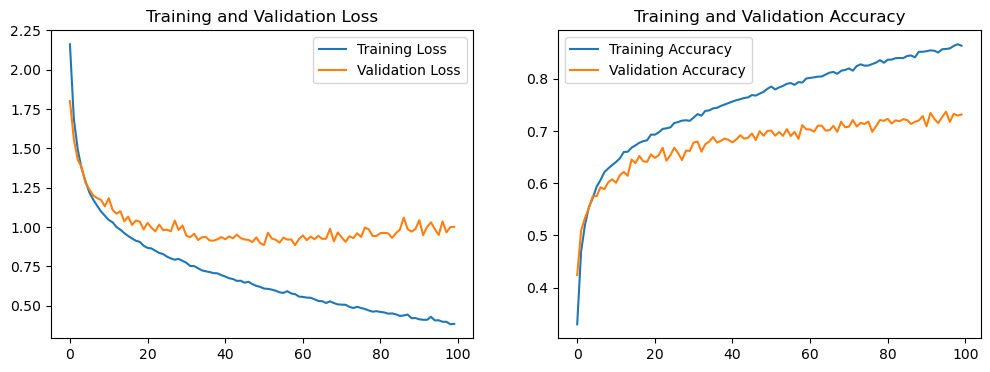

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions and calculate metrics
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

print("\n")

# For a detailed classification report including precision, recall, f1-score per class
print(classification_report(y_test, predicted_classes))

110/110 [==============================] - 1s 6ms/step
Precision: 0.7375853493125972, Recall: 0.7314709236031927, F1-Score: 0.7264296546931768


              precision    recall  f1-score   support

           0       0.79      0.76      0.77       235
           1       0.97      1.00      0.98       222
           2       0.61      0.61      0.61       233
           3       0.72      0.61      0.66       211
           4       0.71      0.69      0.70       224
           5       0.67      0.73      0.70       220
           6       0.74      0.65      0.69       223
           7       0.95      0.98      0.97       239
           8       0.64      0.83      0.73       222
           9       0.92      0.99      0.95       198
          10       0.55      0.49      0.52       205
          11       0.79      0.38      0.51       223
          12       0.63      0.53      0.58       236
          13       0.60      0.65      0.63       178
          14       0.54      0.80      0.65 